In [1]:
!wget https://technionmail-my.sharepoint.com/:u:/g/personal/ploznik_campus_technion_ac_il/EQc79uRBeO1FqtH6ILFDx78BuuWui3DuRaBtnzTB6Aqxqg?download=1 -O data.tar 

--2023-05-11 15:49:27--  https://technionmail-my.sharepoint.com/:u:/g/personal/ploznik_campus_technion_ac_il/EQc79uRBeO1FqtH6ILFDx78BuuWui3DuRaBtnzTB6Aqxqg?download=1
Resolving technionmail-my.sharepoint.com (technionmail-my.sharepoint.com)... 13.107.136.8, 13.107.138.8, 2620:1ec:8f8::8, ...
Connecting to technionmail-my.sharepoint.com (technionmail-my.sharepoint.com)|13.107.136.8|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/ploznik_campus_technion_ac_il/Documents/HW1_data/data.tar?ga=1 [following]
--2023-05-11 15:49:28--  https://technionmail-my.sharepoint.com/personal/ploznik_campus_technion_ac_il/Documents/HW1_data/data.tar?ga=1
Reusing existing connection to technionmail-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 212420608 (203M) [application/x-tar]
Saving to: ‘data.tar’

data.tar            100%[===================>] 202.58M  49.2MB/s    in 5.8s    

2023-05-11 15:49:35 (35.1 MB/s) - ‘data.tar’ saved [2

In [2]:
!tar -xvf data.tar

Streaming output truncated to the last 5000 lines.
data/train/patient_5499.psv
data/train/patient_55.psv
data/train/patient_550.psv
data/train/patient_5500.psv
data/train/patient_5501.psv
data/train/patient_5502.psv
data/train/patient_5503.psv
data/train/patient_5504.psv
data/train/patient_5505.psv
data/train/patient_5506.psv
data/train/patient_5507.psv
data/train/patient_5508.psv
data/train/patient_5509.psv
data/train/patient_551.psv
data/train/patient_5510.psv
data/train/patient_5511.psv
data/train/patient_5512.psv
data/train/patient_5513.psv
data/train/patient_5514.psv
data/train/patient_5515.psv
data/train/patient_5516.psv
data/train/patient_5517.psv
data/train/patient_5518.psv
data/train/patient_5519.psv
data/train/patient_552.psv
data/train/patient_5520.psv
data/train/patient_5521.psv
data/train/patient_5522.psv
data/train/patient_5523.psv
data/train/patient_5524.psv
data/train/patient_5525.psv
data/train/patient_5526.psv
data/train/patient_5527.psv
data/train/patient_5528.psv
da

In [4]:
import pandas as pd
import numpy as np
import os
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.utils import pad_sequences
from sklearn.metrics import f1_score
import tensorflow as tf
from keras import backend as K
import torch
import torch.nn as nn
from tensorflow.python.client import device_lib
import glob

In [5]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
K.set_session(sess)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [6]:
train_path = 'data/train'
test_path = 'data/test'
LABEL_COL = 'SepsisLabel'

In [7]:
def process_file(file_path, fill=False):
    df = pd.read_csv(file_path, sep='|').assign(patient_id=os.path.basename(file_path).split('.')[0])
    df = df.fillna(method="ffill")
    # df = df.fillna(method='bfill')
    """
    df = df.drop(columns=['HR','EtCO2','BaseExcess','HCO3','FiO2' ,'pH','PaCO2','SaO2','AST','BUN','Alkalinephos',
                          'Calcium','Chloride','Creatinine','Bilirubin_direct','Lactate','Magnesium','Phosphate',
                          'Potassium','Bilirubin_total','TroponinI','Hct','Hgb','PTT','WBC','Fibrinogen',
                          'Platelets'])
    if fill:
        df = df.ffill().fillna(df.mean()).fillna(avg_df)
    """
    if 1 in df[LABEL_COL].values:
        idx = df.index[df[LABEL_COL] == 1][0]
    else:
        idx = -1

    if idx >= 0:
        new_df = df.loc[:idx]
        y = 1
    else:
        new_df = df
        y = 0
    """
    last_hour_data = df.tail(1).reset_index(drop=True)
    avg_data = df.mean().to_frame().T.reset_index(drop=True)
    first_hour_data = df.iloc[0]
    diff_data = last_hour_data.subtract(first_hour_data).reset_index(drop=True)
    result = pd.concat([last_hour_data, avg_data, diff_data], axis=1)
    result.columns = ['last_hour_' + str(col) for col in result.columns[:40]] + ['avg_' + str(col) for col in
                            result.columns[40:80]] + ['diff_' + str(col) for col in result.columns[80:]]
    X = result
    """
    X = new_df
    return X, y

In [8]:
def process_set(path, fill=False):
    feature_list = []
    label_list = []
    name_list = []
    for file_name in os.listdir(path):
        file_path = os.path.join(path, file_name)
        X, y = process_file(file_path, fill)
        feature_list.append(X)
        label_list.append(y)
        name_list.append(file_name)
    return feature_list, label_list, name_list


In [9]:
train_features, train_labels, train_names = process_set(train_path)
train_df = pd.concat(train_features)
train_nans = train_df.isna().sum().sum()
test_features, test_labels, test_names = process_set(test_path)
test_df = pd.concat(test_features)
test_nans = test_df.isna().sum().sum()

In [9]:
sum(train_labels) + sum(test_labels)

2156

In [10]:
N_train = train_df.groupby("patient_id")["patient_id"].count().count()
N_test = test_df.groupby("patient_id")["patient_id"].count().count()

print(f"Train set contains {train_df.shape[0]} total records of {N_train} patients") 
print(f"Train NaN values: {train_nans}")

print(f"Test set contains {test_df.shape[0]} total records of {N_test} patients") 
print(f"Test NaN values: {test_nans}")

Train set contains 754817 total records of 20000 patients
Train NaN values: 11328503
Test set contains 379541 total records of 10000 patients
Test NaN values: 5676961


Text(0.5, 0, 'records')

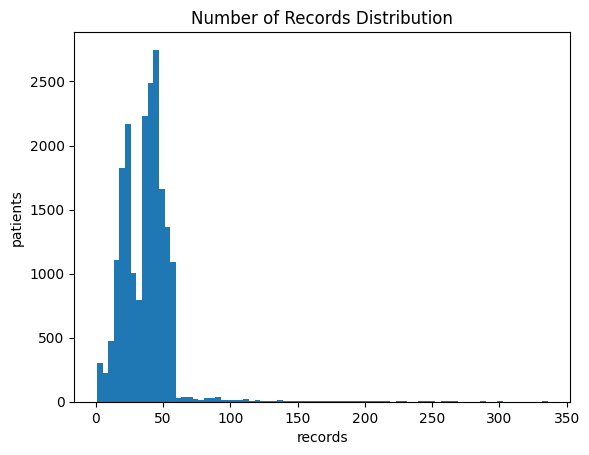

In [10]:
import matplotlib.pyplot as plt

train_df.groupby("patient_id")["patient_id"].count().plot(kind='hist', bins=80, title='Number of Records Distribution')
plt.ylabel("patients")
plt.xlabel("records")

<Axes: title={'center': 'Missing Values Records Per Feature'}>

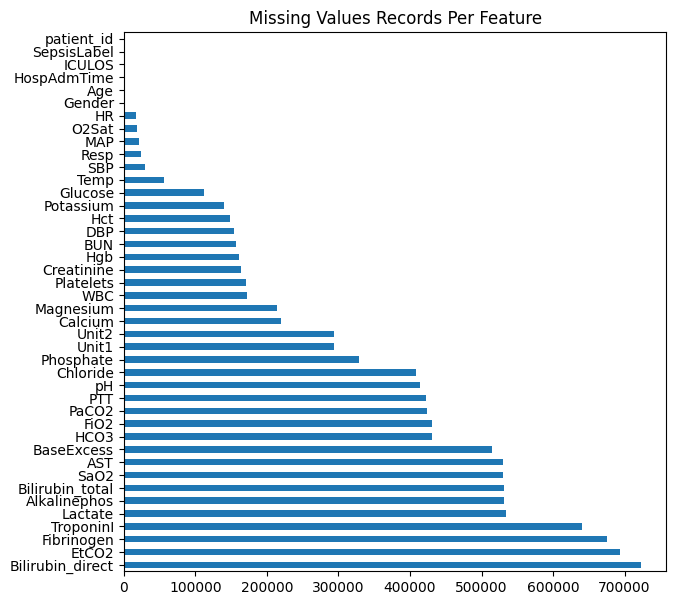

In [12]:
train_df.isna().sum().sort_values(ascending=False).plot(kind='barh',title='Missing Values Records Per Feature',figsize=(7,7))

In [13]:
train_df.describe()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
count,737279.000000,735950.000000,698766.000000,725034.000000,733791.000000,600853.000000,731359.000000,60603.000000,239516.000000,324552.000000,...,582606.000000,79339.000000,584000.000000,754817.000000,754817.000000,461114.000000,461114.000000,754817.000000,754817.000000,754817.000000
mean,84.359724,97.140528,36.868056,123.477638,82.545677,64.085731,18.692687,33.643929,-0.203177,24.321895,...,11.258787,302.757815,205.537985,62.033249,0.555015,0.493574,0.506426,-54.724323,26.104538,0.001875
std,17.405247,3.153895,0.718377,23.113754,16.301190,14.050659,5.125048,11.187473,4.056838,4.217617,...,6.824129,156.731243,103.592007,16.409864,0.496964,0.499959,0.499959,168.419139,26.971131,0.043256
min,20.000000,20.000000,20.900000,20.000000,20.000000,20.000000,1.000000,10.000000,-32.000000,0.000000,...,0.100000,35.000000,2.000000,15.000000,0.000000,0.000000,0.000000,-5366.860000,1.000000,0.000000
25%,72.000000,96.000000,36.400000,107.000000,71.000000,54.000000,15.500000,28.000000,-2.000000,22.000000,...,7.600000,197.000000,138.000000,51.640000,0.000000,0.000000,0.000000,-45.450000,11.000000,0.000000
50%,83.000000,98.000000,36.830000,121.000000,81.000000,62.000000,18.000000,34.000000,0.000000,24.000000,...,10.200000,259.000000,190.000000,64.000000,1.000000,0.000000,1.000000,-5.980000,21.000000,0.000000
75%,95.000000,99.000000,37.300000,138.000000,92.000000,72.000000,21.000000,39.000000,2.000000,27.000000,...,13.600000,371.000000,252.000000,74.000000,1.000000,1.000000,1.000000,-0.040000,34.000000,0.000000
max,280.000000,100.000000,50.000000,299.000000,300.000000,300.000000,100.000000,100.000000,49.500000,55.000000,...,440.000000,1760.000000,2322.000000,100.000000,1.000000,1.000000,1.000000,17.340000,336.000000,1.000000


In [ ]:
import seaborn as sns

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(12, 12), sharex=False, sharey=False)
axes = axes.ravel()  # array to 1D
cols = ['HR', 'Temp', 'Resp', 'BaseExcess', 'pH', 'BUN', 'Magnesium', 'Hct',
       'Hgb', 'WBC', 'Fibrinogen', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS']

for col, ax in zip(cols, axes):
    sns.kdeplot(data=train_df[col], ax=ax)
    ax.set(title=f'Distribution of Column: {col}', xlabel=None)
    
#fig.delaxes(axes[5])  # delete the empty subplot
fig.tight_layout()
plt.show()

<ipython-input-14-1ddcb02a47b9>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = train_df.corr()


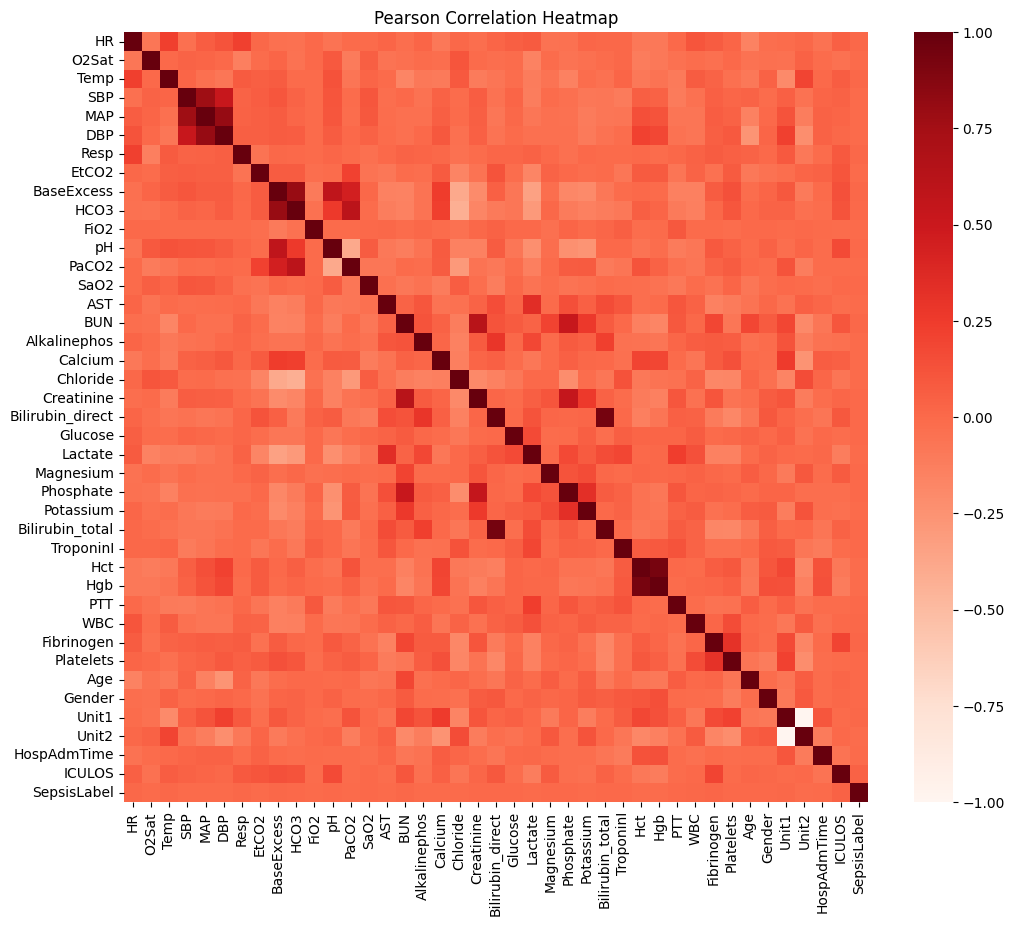

In [14]:
import seaborn as sns

plt.figure(figsize=(12,10))
cor = train_df.corr()
sns.heatmap(cor, cmap=plt.cm.Reds)
plt.title("Pearson Correlation Heatmap")
plt.show()

Text(0.5, 0, 'correlation')

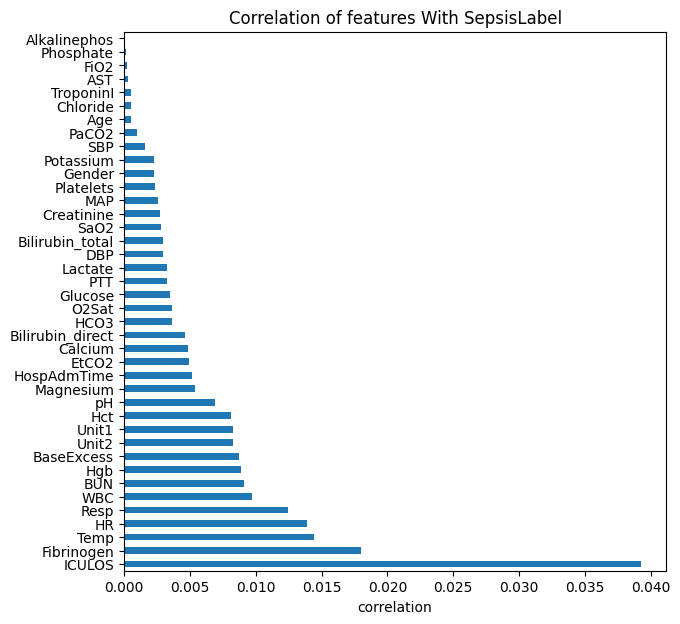

In [15]:
cor_target = abs(cor["SepsisLabel"])
cor_target[:-1].sort_values(ascending=False).plot(kind="barh",figsize=(7,7),title="Correlation of features With SepsisLabel")
plt.xlabel("correlation")

In [20]:
#Correlation with output variable
cor_target = abs(cor["SepsisLabel"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.005]
relevant_features.index

Index(['HR', 'Temp', 'Resp', 'BaseExcess', 'pH', 'BUN', 'Magnesium', 'Hct',
       'Hgb', 'WBC', 'Fibrinogen', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS',
       'SepsisLabel'],
      dtype='object')

In [ ]:
def process_file(file_path, avg_df, fill=False):
    df = pd.read_csv(file_path, sep='|')
    """ df = df.drop(columns=['HR','EtCO2','BaseExcess','HCO3','FiO2' ,'pH','PaCO2','SaO2','AST','BUN','Alkalinephos',
                          'Calcium','Chloride','Creatinine','Bilirubin_direct','Lactate','Magnesium','Phosphate',
                          'Potassium','Bilirubin_total','TroponinI','Hct','Hgb','PTT','WBC','Fibrinogen',
                          'Platelets'])"""

    if 1 in df[LABEL_COL].values:
        idx = df.index[df[LABEL_COL] == 1][0]
    else:
        idx = -1

    if idx >= 0:
        new_df = df.loc[:idx]
        y = 1
    else:
        new_df = df
        y = 0
    new_df = new_df[new_df.columns.drop([LABEL_COL])]
    if fill:
        X = new_df.mean().fillna(avg_df)
    else:
        X = new_df
    return X, y

In [ ]:
def process_file_last(file_path, avg_df, fill=False):
    df = pd.read_csv(file_path, sep='|')
    """ df = df.drop(columns=['HR','EtCO2','BaseExcess','HCO3','FiO2' ,'pH','PaCO2','SaO2','AST','BUN','Alkalinephos',
                          'Calcium','Chloride','Creatinine','Bilirubin_direct','Lactate','Magnesium','Phosphate',
                          'Potassium','Bilirubin_total','TroponinI','Hct','Hgb','PTT','WBC','Fibrinogen',
                          'Platelets'])"""

    if 1 in df[LABEL_COL].values:
        idx = df.index[df[LABEL_COL] == 1][0]
    else:
        idx = -1

    if idx >= 0:
        new_df = df.loc[:idx]
        y = 1
    else:
        new_df = df
        y = 0
    new_df = new_df[new_df.columns.drop([LABEL_COL])]
    if fill:
        new_df = new_df.ffill().fillna(avg_df)
    df = new_df
    last_hour_data = df.tail(1).reset_index(drop=True)
    avg_data = df.mean().to_frame().T.reset_index(drop=True)
    first_hour_data = df.iloc[0]
    diff_data = last_hour_data.subtract(first_hour_data).reset_index(drop=True)
    result = pd.concat([last_hour_data, avg_data, diff_data], axis=1)
    result.columns = ['last_hour_' + str(col) for col in result.columns[:40]] + ['avg_' + str(col) for col in
                            result.columns[40:80]] + ['diff_' + str(col) for col in result.columns[80:]]
    X = result
    return X, y

In [ ]:
def process_set(path, avg_df, fill=False, last=False):
    feature_list = []
    label_list = []
    name_list = []
    i = 0
    for file_name in os.listdir(path):
        file_path = os.path.join(path, file_name)
        if last:
            X, y = process_file_last(file_path, avg_df, fill)
        else:
            X, y = process_file(file_path, avg_df, fill)
        feature_list.append(X)
        label_list.append(y)
        name_list.append(file_name)
        """i += 1
        if i > 80:
            break"""
    if fill:
        df = pd.concat(feature_list)
        df['label'] = label_list
        df['patient'] = name_list
        df.set_index('patient', inplace=True)
        return df
    return feature_list


In [8]:
train_features, train_labels, train_names = process_set(train_path)
test_features, test_labels, test_names = process_set(test_path)

In [ ]:
train_labels

In [9]:
train_df = pd.concat(train_features)
test_df = pd.concat(test_features)

In [10]:
nans = train_df.isna().sum().sum()

print(nans)

11328503


In [ ]:
train_df["HR"].plot(kind='line')

In [12]:
batch_size = 1
train_avgs, _, _ = process_set(train_path, 0, False)
avg_df = pd.concat(train_avgs).mean()
print(pd.concat(train_avgs).isna().sum())
train_features, train_labels, train_names = process_set(train_path, avg_df, True)
test_features, test_labels, test_names = process_set(test_path, avg_df, True)
train_labels = np.array(train_labels)

test_labels = np.array(test_labels)
test_labels = [int(t) for t in test_labels]
max_length = max([t.shape[0] for t in train_features])
train_X = pad_sequences(train_features, maxlen=max_length, dtype='float32', padding='post', truncating='post')
test_X = pad_sequences(test_features, maxlen=max_length, dtype='float32', padding='post', truncating='post')

O2Sat           99034
Temp           498868
SBP            111038
MAP             94738
DBP            235672
Resp           116701
Glucose        625368
Age                 0
Gender              0
Unit1          293703
Unit2          293703
HospAdmTime         0
ICULOS              0
dtype: int64


In [9]:
train_labels[0]

0

In [14]:
model = Sequential()
model.add(LSTM(batch_size, input_shape=(None, train_X[0].shape[1])))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_X, train_labels, epochs=2, batch_size=batch_size)
test_pred = model.predict(test_X, batch_size=batch_size).flatten()
test_pred = [1 if t >= 0.5 else 0 for t in test_pred]
test_f1 = f1_score(test_labels, test_pred)
print("Test F1 score:", test_f1)

Epoch 1/2
20000/20000 [==============================] - 251s 12ms/step - loss: 0.2622 - accuracy: 0.9293
Epoch 2/2
10000/10000 [==============================] - 58s 6ms/step
Test F1 score: 0.0


In [16]:
sum(test_pred)

0

In [ ]:
if __name__ == '__main__':
    batch_size = 64
    train_avgs, _, _ = process_set(train_path, 0, False)
    avg_df = pd.concat(train_avgs).mean()
    print(pd.concat(train_avgs).isna().sum())
    train_features, train_labels, train_names = process_set(train_path, avg_df, True)
    test_features, test_labels, test_names = process_set(test_path, avg_df, True)
    train_labels = np.array(train_labels)

    test_labels = np.array(test_labels)
    test_labels = [int(t) for t in test_labels]
    max_length = max([t.shape[0] for t in train_features])
    train_X = pad_sequences(train_features, maxlen=max_length, dtype='float32', padding='post', truncating='post')
    test_X = pad_sequences(test_features, maxlen=max_length, dtype='float32', padding='post', truncating='post')
    model = Sequential()
    model.add(LSTM(batch_size, input_shape=(None, train_X[0].shape[1])))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(train_X, train_labels, epochs=10, batch_size=batch_size)
    test_pred = model.predict(test_X, batch_size=batch_size).flatten()
    test_pred = [1 if t >= 0.5 else 0 for t in test_pred]
    test_f1 = f1_score(test_labels, test_pred)
    print("Test F1 score:", test_f1)

    """
    class LSTMClassifier(nn.Module):
        def __init__(self, input_dim, hidden_dim, output_dim):
            super(LSTMClassifier, self).__init__()
            self.hidden_dim = hidden_dim
            self.lstm = nn.LSTM(input_dim, hidden_dim)
            self.fc = nn.Linear(hidden_dim, output_dim)
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            lstm_out, _ = self.lstm(x)
            out = self.fc(lstm_out[:, -1, :])
            out = self.sigmoid(out)
            return out


    # define F1 score as a custom metric
    def f1(y_true, y_pred):
        return f1_score(y_true.cpu().detach().numpy(), y_pred.cpu().detach().numpy())


    # read in your dataframe
    df = pd.read_csv('your_data.csv')

    # separate your features and labels
    X = df.drop('label', axis=1)
    y = df['label']

    # convert your data to PyTorch tensors
    X = torch.tensor(X.values, dtype=torch.float32)
    y = torch.tensor(y.values, dtype=torch.float32)

    # define the maximum number of time steps and features
    max_time_steps = X.shape[1]  # maximum number of rows per sample
    features = X.shape[2]  # number of columns in the dataframe (excluding the label)

    # pad or truncate the sequences as needed
    for i in range(len(X)):
        num_time_steps = X[i].shape[0]
        if num_time_steps < max_time_steps:
            padding = torch.zeros((max_time_steps - num_time_steps, features))
            X[i] = torch.cat((X[i], padding))
        elif num_time_steps > max_time_steps:
            X[i] = X[i][:max_time_steps, :]

    # define your LSTM model
    model = LSTMClassifier(input_dim=features, hidden_dim=50, output_dim=1)

    # define your loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters())

    # train your model
    for epoch in range(50):
        # set the model to training mode
        model.train()
        # zero the gradients for this iteration
        optimizer.zero_grad()
        # make predictions and calculate the loss
        y_pred = model(X)
        loss = criterion(y_pred, y.view(-1, 1))
        # calculate the F1 score
        f1_score = f1(y, y_pred.round())
        # compute gradients and update parameters
        loss.backward()
        optimizer.step()
        # print the loss and F1 score for this epoch
        print('Epoch [{}/{}], Loss: {:.4f}, F1 Score: {:.4f}'.format(epoch+1, 50, loss.item(), f1_score))"""